In [81]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
#import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

In [82]:
TRAIN_PATH="DRIVE/training/"
TEST_PATH="DRIVE/test/"

In [83]:
train_ids=next(os.walk(TRAIN_PATH+'images/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'images/'))[2][:]
print(len(train_ids))

20


In [84]:
input_height = IMG_HEIGHT = 256
input_width = IMG_WIDTH = 256
IMG_CHANNELS = 3

In [85]:

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    print(id_[:2])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + '1st_manual/' + id_[:2] + '_manual1.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + '1st_manual/' + id_[:2] + '_manual1.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

Resizing training images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_20980\452691114.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  5%|████▏                                                                              | 1/20 [00:00<00:02,  6.90it/s]

21
22


 15%|████████████▍                                                                      | 3/20 [00:00<00:01,  8.61it/s]

23
24


 20%|████████████████▌                                                                  | 4/20 [00:00<00:01,  8.16it/s]

25


 25%|████████████████████▊                                                              | 5/20 [00:00<00:01,  8.05it/s]

26


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  8.44it/s]

27


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  7.94it/s]

28


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  8.34it/s]

29
30


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  8.51it/s]

31


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  8.17it/s]

32


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  7.91it/s]

33


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:01<00:00,  7.78it/s]

34


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:01<00:00,  8.28it/s]

35
36


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:01<00:00,  7.74it/s]

37


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  8.01it/s]

38


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  7.87it/s]

39


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:02<00:00,  7.75it/s]

40


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.94it/s]


Resizing test images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_20980\452691114.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.88it/s]


In [86]:
print(X_train.shape, Y_test.shape)

(20, 256, 256, 3) (20, 256, 256, 1)


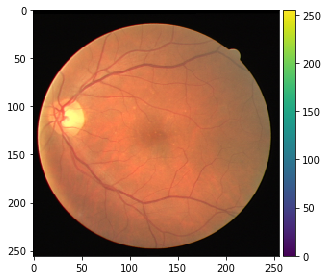

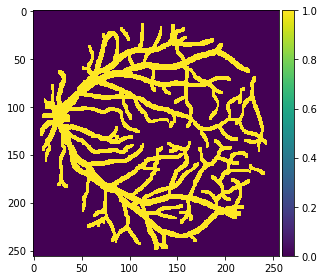

In [87]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

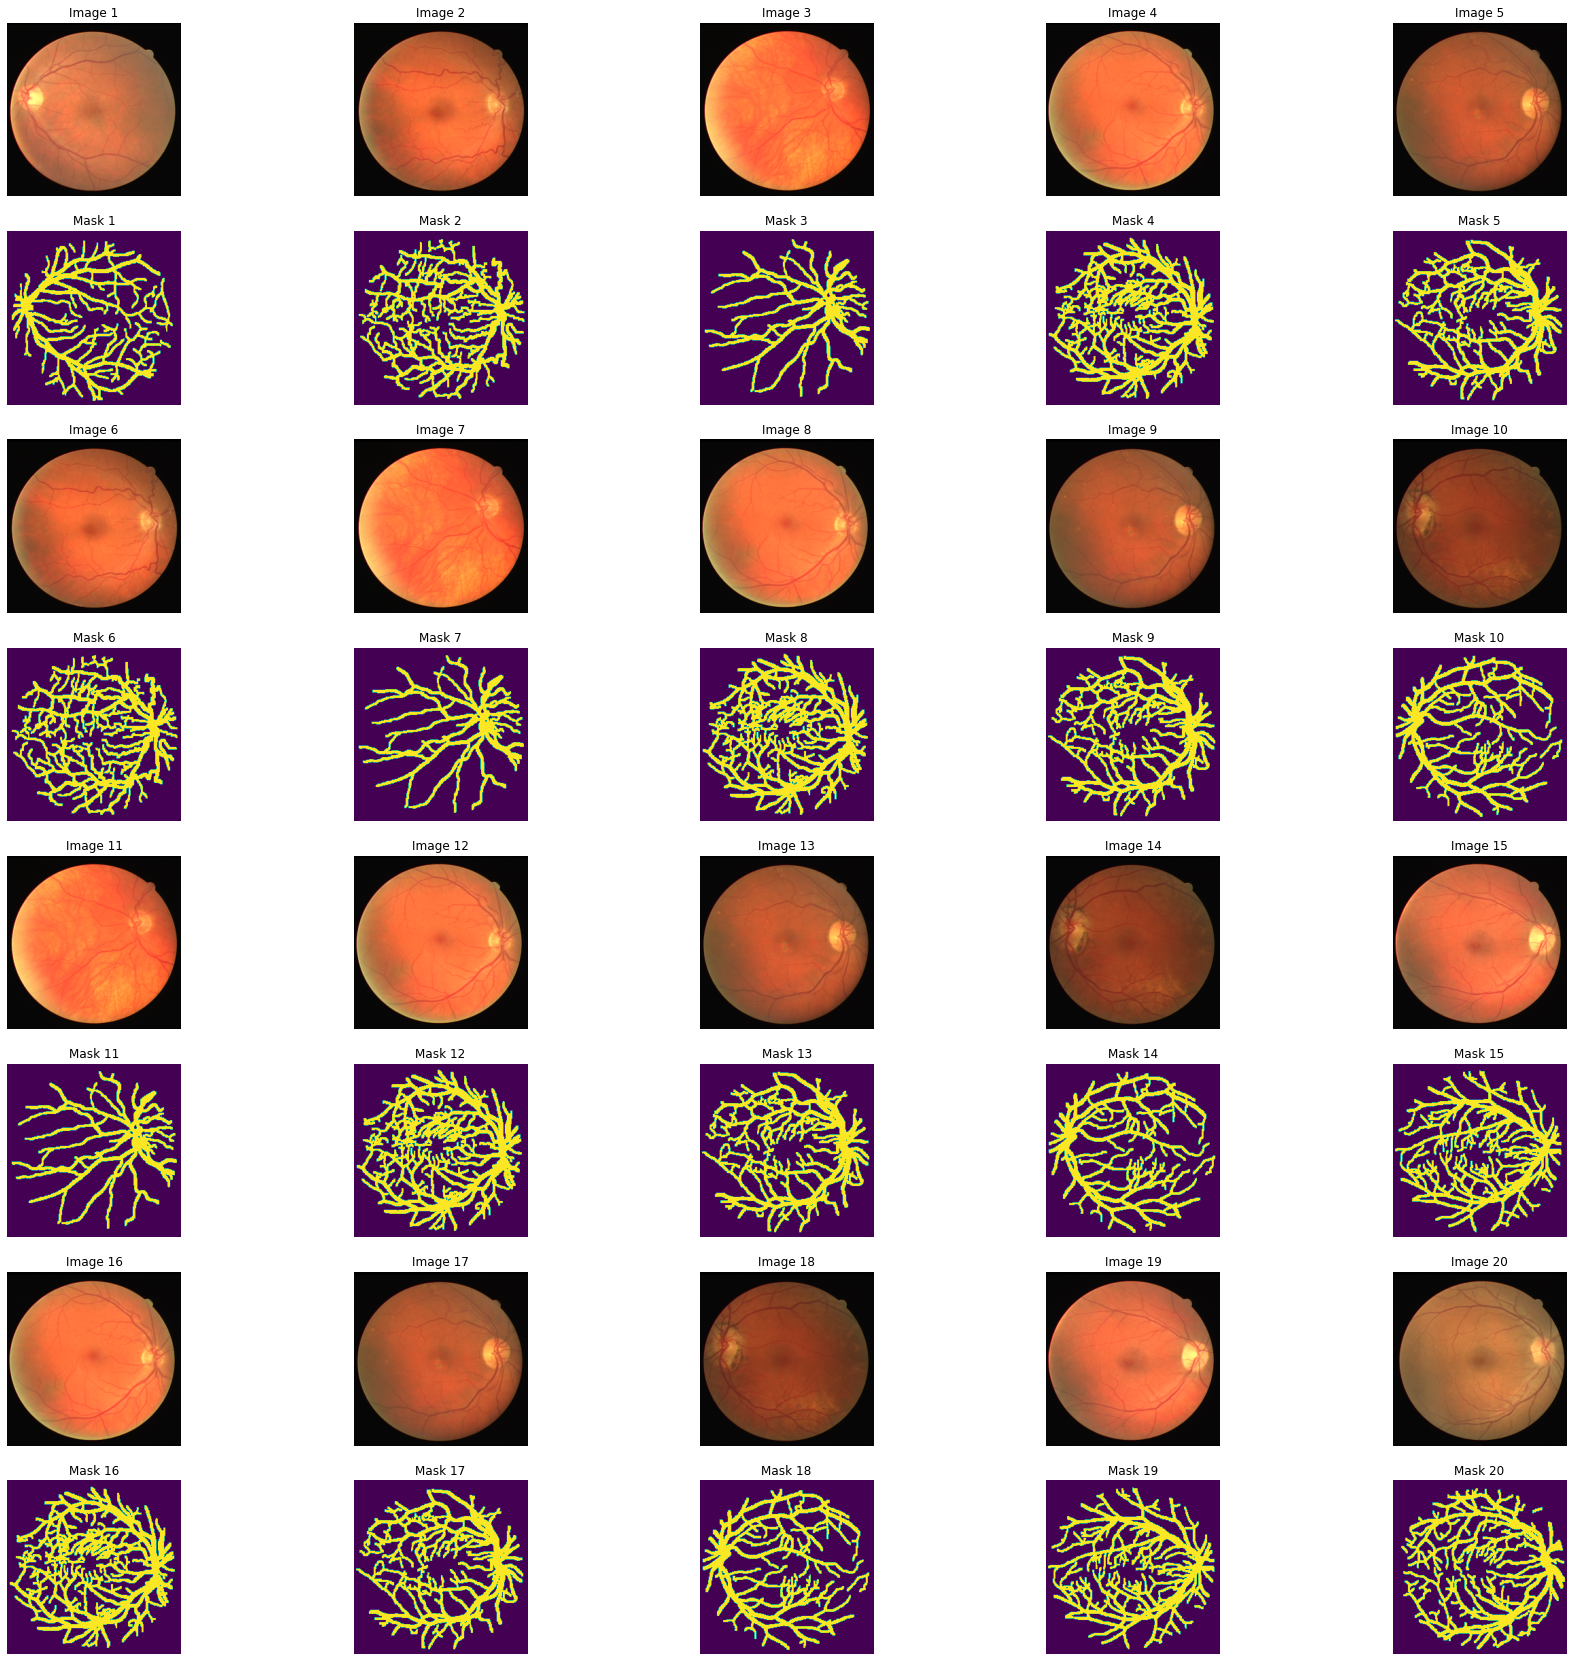

In [88]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [89]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

In [90]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=128):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 96
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image


@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)

def rotation(image):
    augmented_image = tf.image.rot90(image)
    return augmented_image

@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    #image = random_apply(color_jitter, image, p=0.9)
    #image = random_apply(color_drop, image, p=0.3)
    #image = random_apply(solarize, image, p=0.3)
    return image

In [91]:
AUTO = tf.data.AUTOTUNE
CROP_TO = IMG_HEIGHT
SEED = 42
BATCH_SIZE = 4
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

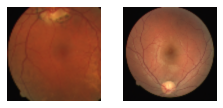

In [92]:
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

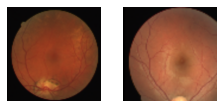

In [93]:
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [94]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss 

In [95]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [96]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Implements an LR scheduler that warms up the learning rate for some training steps
    (usually at the beginning of the training) and then decays it
    with CosineDecay (see https://arxiv.org/abs/1608.03983)
    """

    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [97]:
PROJECT_DIM = IMG_HEIGHT/2
BATCH_SIZE = 8
EPOCHS = 100
WEIGHT_DECAY = 5e-4
TRAIN_FLG = 1 # 0 - No Training, 1 - Training
val_split = 0.3

STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

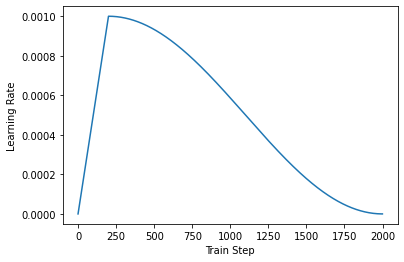

In [98]:
# Visualize the LR schedule
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [99]:
def projection_head(x, hidden_dim=128):
    """Constructs the projection head."""
    for i in range(2):
        x = Dense(
            hidden_dim,
            name=f"projection_layer_{i}",
            kernel_regularizer=l2(WEIGHT_DECAY),
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs

def build_encoder(shape, hidden_dim=128):
    inputs = Input(shape)
    s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    #s = inputs
    x, skip_1 = encoder(s)
    
    x = bottleneck(x)
    
    # Projections
    trunk_output = GlobalAvgPool2D()(x)
    projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)

    model = Model(inputs, projection_outputs)
    return model, skip_1

In [100]:
unet_enc, skip_connetions = build_encoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=PROJECT_DIM)
unet_enc.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 separable_conv2d_36 (Separable  (None, 256, 256, 16  91         ['rescaling_2[0][0]']            
 Conv2D)                        )                                                                 
                                                                                            

                                                                                                  
 batch_normalization_67 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_41[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 64)   2112        ['max_pooling2d_9[0][0]']        
                                                                                                  
 activation_47 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 batch_normalization_68 (BatchN  (None, 64, 64, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
          

 activation_52 (Activation)     (None, 128)          0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 projection_layer_1 (Dense)     (None, 128)          16512       ['activation_52[0][0]']          
                                                                                                  
 batch_normalization_76 (BatchN  (None, 128)         512         ['projection_layer_1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_53 (Activation)     (None, 128)          0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 projection_output (Dense)      (None, 128)          16512       ['activation_53[0][0]']          
          

Training
Epoch 1/1000
5/5 [==============================] - 15s 916ms/step - loss: 65.0520
Epoch 2/1000
5/5 [==============================] - 4s 772ms/step - loss: 49.3759
Epoch 3/1000
5/5 [==============================] - 4s 771ms/step - loss: 40.5954
Epoch 4/1000
5/5 [==============================] - 4s 774ms/step - loss: 42.8032
Epoch 5/1000
5/5 [==============================] - 4s 766ms/step - loss: 33.5416
Epoch 6/1000
5/5 [==============================] - 4s 813ms/step - loss: 48.8359
Epoch 7/1000
5/5 [==============================] - 4s 774ms/step - loss: 32.6861
Epoch 8/1000
5/5 [==============================] - 4s 753ms/step - loss: 34.7001
Epoch 9/1000
5/5 [==============================] - 4s 781ms/step - loss: 28.9775
Epoch 10/1000
5/5 [==============================] - 4s 761ms/step - loss: 30.6650
Epoch 11/1000
5/5 [==============================] - 4s 772ms/step - loss: 30.0885
Epoch 12/1000
5/5 [==============================] - 4s 764ms/step - loss: 32.6590
Epo

5/5 [==============================] - 5s 931ms/step - loss: 32.2493
Epoch 102/1000
5/5 [==============================] - 5s 923ms/step - loss: 29.9539
Epoch 103/1000
5/5 [==============================] - 5s 945ms/step - loss: 36.5775
Epoch 104/1000
5/5 [==============================] - 5s 922ms/step - loss: 30.1214
Epoch 105/1000
5/5 [==============================] - 6s 1s/step - loss: 34.9108
Epoch 106/1000
5/5 [==============================] - 5s 926ms/step - loss: 36.1331
Epoch 107/1000
5/5 [==============================] - 5s 1s/step - loss: 28.6963
Epoch 108/1000
5/5 [==============================] - 5s 927ms/step - loss: 28.8001
Epoch 109/1000
5/5 [==============================] - 5s 1s/step - loss: 35.6401
Epoch 110/1000
5/5 [==============================] - 6s 1s/step - loss: 30.7464
Epoch 111/1000
5/5 [==============================] - 6s 1s/step - loss: 30.2722
Epoch 112/1000
5/5 [==============================] - 5s 1s/step - loss: 31.5881
Epoch 113/1000
5/5 [=====

5/5 [==============================] - 5s 1s/step - loss: 27.9912
Epoch 202/1000
5/5 [==============================] - 5s 992ms/step - loss: 30.7634
Epoch 203/1000
5/5 [==============================] - 5s 998ms/step - loss: 35.5053
Epoch 204/1000
5/5 [==============================] - 5s 989ms/step - loss: 28.6312
Epoch 205/1000
5/5 [==============================] - 6s 1s/step - loss: 29.3103
Epoch 206/1000
5/5 [==============================] - 6s 1s/step - loss: 32.6424
Epoch 207/1000
5/5 [==============================] - 6s 1s/step - loss: 30.2417
Epoch 208/1000
5/5 [==============================] - 5s 1s/step - loss: 29.2370
Epoch 209/1000
5/5 [==============================] - 6s 1s/step - loss: 31.3969
Epoch 210/1000
5/5 [==============================] - 5s 1s/step - loss: 30.1925
Epoch 211/1000
5/5 [==============================] - 5s 1s/step - loss: 36.1522
Epoch 212/1000
5/5 [==============================] - 5s 1s/step - loss: 28.5149
Epoch 213/1000
5/5 [==============

Epoch 300/1000
5/5 [==============================] - 5s 967ms/step - loss: 26.9373
Epoch 301/1000
5/5 [==============================] - 5s 953ms/step - loss: 28.6120
Epoch 302/1000
5/5 [==============================] - 4s 909ms/step - loss: 33.3890
Epoch 303/1000
5/5 [==============================] - 5s 1s/step - loss: 29.0699
Epoch 304/1000
5/5 [==============================] - 5s 1s/step - loss: 28.0926
Epoch 305/1000
5/5 [==============================] - 5s 1s/step - loss: 30.3606
Epoch 306/1000
5/5 [==============================] - 4s 917ms/step - loss: 32.0272
Epoch 307/1000
5/5 [==============================] - 5s 936ms/step - loss: 29.7938
Epoch 308/1000
5/5 [==============================] - 5s 955ms/step - loss: 28.0672
Epoch 309/1000
5/5 [==============================] - 5s 988ms/step - loss: 29.3325
Epoch 310/1000
5/5 [==============================] - 5s 1s/step - loss: 28.0906
Epoch 311/1000
5/5 [==============================] - 5s 1s/step - loss: 27.0539
Epoch 3

5/5 [==============================] - 5s 1s/step - loss: 26.7649
Epoch 400/1000
5/5 [==============================] - 6s 1s/step - loss: 28.8885
Epoch 401/1000
5/5 [==============================] - 6s 1s/step - loss: 27.7808
Epoch 402/1000
5/5 [==============================] - 5s 1s/step - loss: 29.4894
Epoch 403/1000
5/5 [==============================] - 6s 1s/step - loss: 27.3930
Epoch 404/1000
5/5 [==============================] - 5s 1s/step - loss: 28.4257
Epoch 405/1000
5/5 [==============================] - 5s 1s/step - loss: 27.9248
Epoch 406/1000
5/5 [==============================] - 6s 1s/step - loss: 29.8515
Epoch 407/1000
5/5 [==============================] - 5s 981ms/step - loss: 27.9099
Epoch 408/1000
5/5 [==============================] - 5s 1s/step - loss: 27.9854
Epoch 409/1000
5/5 [==============================] - 5s 1s/step - loss: 27.1429
Epoch 410/1000
5/5 [==============================] - 5s 990ms/step - loss: 27.4833
Epoch 411/1000
5/5 [=================

5/5 [==============================] - 5s 927ms/step - loss: 27.1742
Epoch 499/1000
5/5 [==============================] - 4s 905ms/step - loss: 26.9948
Epoch 500/1000
5/5 [==============================] - 5s 964ms/step - loss: 29.4295
Epoch 501/1000
5/5 [==============================] - 5s 926ms/step - loss: 27.1019
Epoch 502/1000
5/5 [==============================] - 5s 983ms/step - loss: 31.6091
Epoch 503/1000
5/5 [==============================] - 4s 917ms/step - loss: 28.0976
Epoch 504/1000
5/5 [==============================] - 5s 970ms/step - loss: 30.5843
Epoch 505/1000
5/5 [==============================] - 5s 957ms/step - loss: 31.4516
Epoch 506/1000
5/5 [==============================] - 5s 973ms/step - loss: 27.4662
Epoch 507/1000
5/5 [==============================] - 5s 951ms/step - loss: 30.9969
Epoch 508/1000
5/5 [==============================] - 5s 908ms/step - loss: 29.8251
Epoch 509/1000
5/5 [==============================] - 5s 896ms/step - loss: 28.5730
Epoch 5

Epoch 596/1000
5/5 [==============================] - 4s 915ms/step - loss: 27.2751
Epoch 597/1000
5/5 [==============================] - 5s 907ms/step - loss: 27.9333
Epoch 598/1000
5/5 [==============================] - 4s 898ms/step - loss: 28.6997
Epoch 599/1000
5/5 [==============================] - 5s 926ms/step - loss: 27.9826
Epoch 600/1000
5/5 [==============================] - 4s 915ms/step - loss: 27.6845
Epoch 601/1000
5/5 [==============================] - 5s 934ms/step - loss: 28.1631
Epoch 602/1000
5/5 [==============================] - 4s 897ms/step - loss: 32.3386
Epoch 603/1000
5/5 [==============================] - 5s 939ms/step - loss: 28.1607
Epoch 604/1000
5/5 [==============================] - 4s 923ms/step - loss: 28.5676
Epoch 605/1000
5/5 [==============================] - 5s 922ms/step - loss: 28.6620
Epoch 606/1000
5/5 [==============================] - 5s 911ms/step - loss: 27.7266
Epoch 607/1000
5/5 [==============================] - 4s 906ms/step - loss: 

5/5 [==============================] - 3s 672ms/step - loss: 29.0583
Epoch 694/1000
5/5 [==============================] - 3s 671ms/step - loss: 28.1930
Epoch 695/1000
5/5 [==============================] - 3s 668ms/step - loss: 29.1111
Epoch 696/1000
5/5 [==============================] - 4s 726ms/step - loss: 29.8401
Epoch 697/1000
5/5 [==============================] - 4s 709ms/step - loss: 26.8050
Epoch 698/1000
5/5 [==============================] - 4s 792ms/step - loss: 30.7630
Epoch 699/1000
5/5 [==============================] - 4s 865ms/step - loss: 28.2554
Epoch 700/1000
5/5 [==============================] - 4s 842ms/step - loss: 28.2376
Epoch 701/1000
5/5 [==============================] - 4s 847ms/step - loss: 29.5152
Epoch 702/1000
5/5 [==============================] - 4s 832ms/step - loss: 28.7100
Epoch 703/1000
5/5 [==============================] - 4s 854ms/step - loss: 29.6379
Epoch 704/1000
5/5 [==============================] - 4s 866ms/step - loss: 28.6152
Epoch 7

5/5 [==============================] - 5s 1s/step - loss: 31.3191
Epoch 794/1000
5/5 [==============================] - 5s 1s/step - loss: 29.5911
Epoch 795/1000
5/5 [==============================] - 6s 1s/step - loss: 28.4000
Epoch 796/1000
5/5 [==============================] - 6s 1s/step - loss: 30.6766
Epoch 797/1000
5/5 [==============================] - 6s 1s/step - loss: 29.7751
Epoch 798/1000
5/5 [==============================] - 6s 1s/step - loss: 28.3711
Epoch 799/1000
5/5 [==============================] - 6s 1s/step - loss: 30.6198
Epoch 800/1000
5/5 [==============================] - 5s 1s/step - loss: 28.3461
Epoch 801/1000
5/5 [==============================] - 5s 1s/step - loss: 30.9022
Epoch 802/1000
5/5 [==============================] - 5s 1s/step - loss: 26.9593
Epoch 803/1000
5/5 [==============================] - 6s 1s/step - loss: 27.6558
Epoch 804/1000
5/5 [==============================] - 6s 1s/step - loss: 27.6368
Epoch 805/1000
5/5 [=======================

5/5 [==============================] - 6s 1s/step - loss: 30.7248
Epoch 895/1000
5/5 [==============================] - 6s 1s/step - loss: 27.0695
Epoch 896/1000
5/5 [==============================] - 5s 1s/step - loss: 28.6452
Epoch 897/1000
5/5 [==============================] - 5s 1s/step - loss: 27.7937
Epoch 898/1000
5/5 [==============================] - 6s 1s/step - loss: 28.9340
Epoch 899/1000
5/5 [==============================] - 7s 1s/step - loss: 27.0883
Epoch 900/1000
5/5 [==============================] - 6s 1s/step - loss: 29.4870
Epoch 901/1000
5/5 [==============================] - 6s 1s/step - loss: 27.3282
Epoch 902/1000
5/5 [==============================] - 6s 1s/step - loss: 30.6196
Epoch 903/1000
5/5 [==============================] - 6s 1s/step - loss: 30.0896
Epoch 904/1000
5/5 [==============================] - 6s 1s/step - loss: 27.8357
Epoch 905/1000
5/5 [==============================] - 5s 1s/step - loss: 28.9477
Epoch 906/1000
5/5 [=======================

5/5 [==============================] - 6s 1s/step - loss: 28.6479
Epoch 996/1000
5/5 [==============================] - 6s 1s/step - loss: 27.5004
Epoch 997/1000
5/5 [==============================] - 6s 1s/step - loss: 27.3410
Epoch 998/1000
5/5 [==============================] - 6s 1s/step - loss: 27.1435
Epoch 999/1000
5/5 [==============================] - 5s 1s/step - loss: 28.1561
Epoch 1000/1000
5/5 [==============================] - 6s 1s/step - loss: 29.8199


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


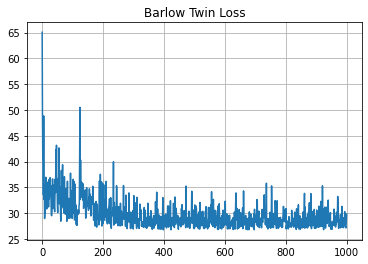

In [101]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins = BarlowTwins(unet_enc)
barlow_twins.compile(optimizer=optimizer)
if TRAIN_FLG:
    print("Training")
    barlow_twins.encoder.get_weights()[0]
    history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)
    barlow_twins.encoder.save('barlow_twins_unet')
    plt.plot(history.history["loss"])
    plt.grid()
    plt.title("Barlow Twin Loss")
    plt.show()
elif not TRAIN_FLG:
    print("Loading training weights")
    barlow_twins.encoder.load_weights('barlow_twins_unet')

In [102]:
backbone = tf.keras.Model(
    barlow_twins.encoder.input, barlow_twins.encoder.layers[-9].output
)
backbone.layers

In [103]:
backbone.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 separable_conv2d_36 (Separable  (None, 256, 256, 16  91         ['rescaling_2[0][0]']            
 Conv2D)                        )                                                                 
                                                                                            

                                                                                                  
 batch_normalization_67 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_41[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 64)   2112        ['max_pooling2d_9[0][0]']        
                                                                                                  
 activation_47 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 batch_normalization_68 (BatchN  (None, 64, 64, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
          

In [104]:
new_skip_connections = [backbone.get_layer(index=11).output, 
                        backbone.get_layer(index=22).output, 
                        backbone.get_layer(index=33).output, 
                        backbone.get_layer(index=44).output]

In [105]:
new_skip_connections

[<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'add_18')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'add_19')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'add_20')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'add_21')>]

In [106]:
backbone.output

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'add_22')>

In [107]:
backbone.trainable=True
x = backbone.output
#x = bottleneck(x)
x = decoder(x, new_skip_connections)
outputs = output(x)
model = Model(barlow_twins.encoder.input, outputs)

In [108]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 separable_conv2d_36 (Separable  (None, 256, 256, 16  91         ['rescaling_2[0][0]']            
 Conv2D)                        )                                                                 
                                                                                            

                                                                                                  
 batch_normalization_67 (BatchN  (None, 64, 64, 64)  256         ['separable_conv2d_41[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 64)   2112        ['max_pooling2d_9[0][0]']        
                                                                                                  
 activation_47 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 batch_normalization_68 (BatchN  (None, 64, 64, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 separable_conv2d_47 (Separable  (None, 32, 32, 128)  17664      ['activation_54[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_78 (BatchN  (None, 32, 32, 128)  512        ['separable_conv2d_47[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 conv2d_25

 dropout_25 (Dropout)           (None, 128, 128, 32  0           ['activation_59[0][0]']          
                                )                                                                 
                                                                                                  
 add_25 (Add)                   (None, 128, 128, 32  0           ['batch_normalization_85[0][0]', 
                                )                                 'dropout_25[0][0]']             
                                                                                                  
 up_sampling2d_11 (UpSampling2D  (None, 256, 256, 32  0          ['add_25[0][0]']                 
 )                              )                                                                 
                                                                                                  
 concatenate_11 (Concatenate)   (None, 256, 256, 48  0           ['up_sampling2d_11[0][0]',       
          

In [109]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    #print('IOU {}'.format(iou))
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1-tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    #loss = -tf.map_fn(my_iou_metric_loss(label, pred), tf.range(tf.shape(pred)[0]))
    loss.set_shape((None,))

    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    return hausdorff_distance(y_true,y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape)==2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd/batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt,pred,target_size=(256,256),flag_multi_class = False,num_class = 2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
    
    hd = haud_dist_batch(gt,pred)
    
    miou = iou_metric_batch(gt,pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    print("Accuracy=",r_acc, "Precision=",r_pr, "Recall=",r_rc, "MeanIoU=",r_mi, "DiceCoefficient=",dc, "HD=",hd, "MyIoU=",miou, "MAE=",r_mae)

In [110]:
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

In [111]:
log_path = "logs/"
keyname = "BT-Unet"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [121]:
model.compile(
    loss=bce_dice_loss,
    optimizer=Adam(),
    metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_haud_dist, my_iou_metric]
   )
if TRAIN_FLG:
    print("Training")
    callbacks = [
        model_checkpoint,
        reduce_lr,
        csv_logger,
        tensorboard_callback,
        early_stopping
    ]
    X_train_20 = X_train[:int(X_train.shape[0]*0.2)]
    Y_train_20 = Y_train[:int(Y_train.shape[0]*0.2)]
    results = model.fit(X_train_20, Y_train_20, validation_split=val_split, batch_size=8, epochs=200, callbacks=callbacks)
elif not TRAIN_FLG:
    print("Loading training weights")
    model.load_weights('model_'+keyname+'.hdf5')

Training
Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.6869 - precision_30: 0.4661 - mean_io_u_30: 0.3614 - recall_30: 0.8920 - dice_coeff: 0.4923 - mean_absolute_error: 0.3910 - my_haud_dist: 8.0090 - my_iou_metric: 0.0000e+00
Epoch 1: loss did not improve from 0.30291


KeyError: 'mean_io_u_20'

In [113]:
preds_train = model.predict(X_train_20[:int(X_train_20.shape[0]*(1-val_split))], verbose=1)
preds_x = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train_20[int(X_train_20.shape[0]*(1-val_split)):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

gt_train = Y_train_20[:int(X_train_20.shape[0]*(1-val_split))].astype(np.float32)
gt_x = Y_train.astype(np.float32)
gt_val = Y_train_20[int(X_train.shape[0]*(1-val_split)):].astype(np.float32)
gt_test = Y_test.astype(np.float32)

1/1 [==============================] - 2s 2s/step


In [114]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_x_t = (preds_x > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

In [115]:
evalResult(gt_train, preds_train_t)

Accuracy= 0.61492157 Precision= 0.41388968 Recall= 0.93575203 MeanIoU= 0.44126546 DiceCoefficient= 0.5727551281452179 HD= 10.558055070088436 MyIoU= 0.0 MAE= 0.38507843


In [116]:
evalResult(gt_x, preds_x_t)

Accuracy= 0.6332451 Precision= 0.42281172 Recall= 0.8606274 MeanIoU= 0.45651805 DiceCoefficient= 0.563959288597107 HD= 10.568028374054027 MyIoU= 0.0003125 MAE= 0.36675492


In [117]:
evalResult(gt_test, preds_test_t)

Accuracy= 0.6348923 Precision= 0.43366572 Recall= 0.90724474 MeanIoU= 0.4611727 DiceCoefficient= 0.5856484919786453 HD= 10.674630674480628 MyIoU= 0.0 MAE= 0.36510772


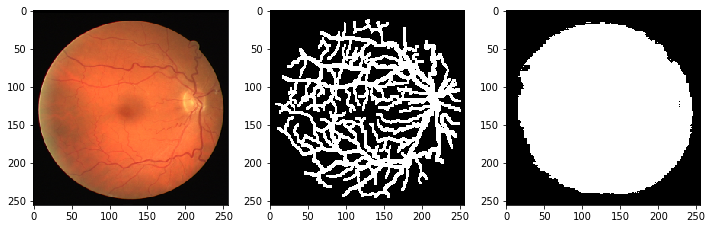

Accuracy= 0.64045715 Precision= 0.4561716 Recall= 0.9360072 MeanIoU= 0.46967715 DiceCoefficient= 0.610280668035557 HD= 10.723805294763608 MyIoU= 0.0011604281135531136 MAE= 0.35954285


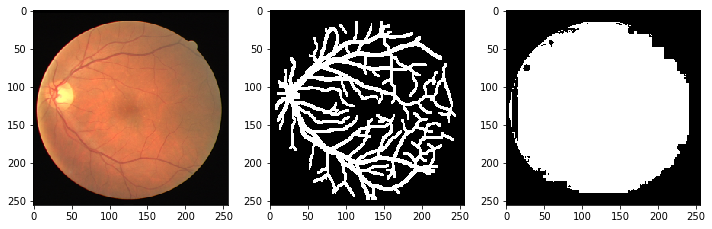

Accuracy= 0.589386 Precision= 0.37178957 Recall= 0.9354405 MeanIoU= 0.4134031 DiceCoefficient= 0.5453232427680632 HD= 10.392304845413264 MyIoU= 7.102272727272727e-05 MAE= 0.410614


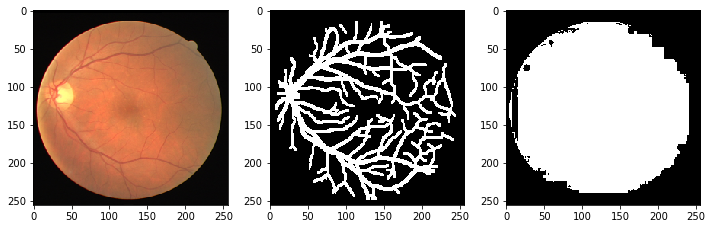

Accuracy= 0.589386 Precision= 0.37178957 Recall= 0.9354405 MeanIoU= 0.4134031 DiceCoefficient= 0.5453232427680632 HD= 10.392304845413264 MyIoU= 7.102272727272727e-05 MAE= 0.410614


In [118]:
x=0

xx = [1,0,0]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_train[:int(X_train.shape[0]*(1-val_split))][ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_train_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix], preds_train_t[ix])
    x = x+3

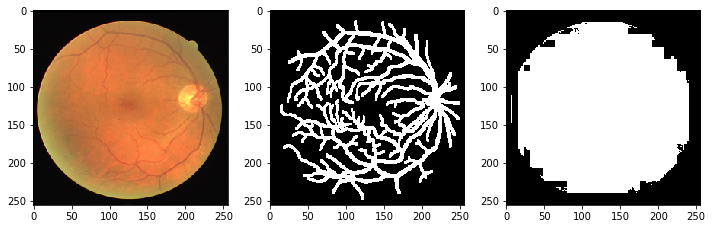

Accuracy= 0.6207428 Precision= 0.4123194 Recall= 0.96526873 MeanIoU= 0.44705135 DiceCoefficient= 0.5759264604421332 HD= 10.862780491200215 MyIoU= 0.0014597641941391938 MAE= 0.3792572


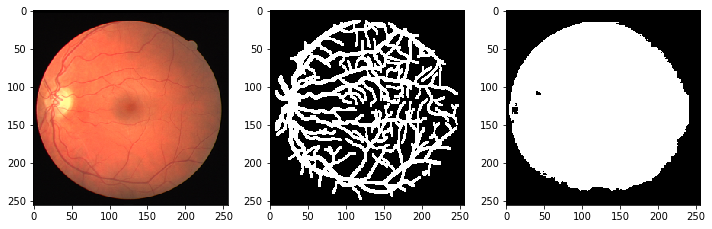

Accuracy= 0.6403351 Precision= 0.4652865 Recall= 0.909656 MeanIoU= 0.46976876 DiceCoefficient= 0.6087624049832812 HD= 10.723805294763608 MyIoU= 0.0016884385146103895 MAE= 0.35966492


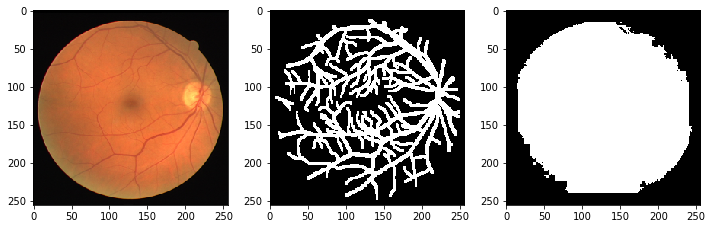

Accuracy= 0.62953186 Precision= 0.43423328 Recall= 0.94495654 MeanIoU= 0.45725816 DiceCoefficient= 0.5852345251623774 HD= 10.677078252031311 MyIoU= 0.0027994791666666667 MAE= 0.37046814


In [122]:
x=0
xx = [16,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_test[ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_test[ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_test_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_test[ix], preds_test_t[ix])
    x = x+3


In [120]:
import winsound
winsound.Beep(2500,1000)